In [1]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.stats.mstats import gmean
import math
import enum;
import os
import lasio
import welly
import shutil

In [2]:
#Modelo Crain
def Correccion_Crain(RESD,RESM,RESS):
    if RESD<RESM and RESM<RESS:
        H = RESS/RESD - 1
        B = RESM/RESD - 1
        C = H/B
        D = 0.59*H-2.21*C+1.35
        E = -1.44*H+2.47*C-2.76
        G = -0.5* ((D**2 - 4*E)**0.5+D)
        RESDc = G*RESD
    else:
        RESDc = RESD
    return RESDc
def Invasion_Crain(RESD,RESM,RESDc):
    C =(RESM/RESDc)*(RESD-RESDc)/(RESM-RESD)
    Di = 33*(C+1)-min(100,10**(0.5*C-0.04))
    if Di<0 or Di>100:
        Di=0
    elif Di>32 and Di<32.1:
        Di=0
    return Di


In [3]:
#Modelo Propuesto
def Rxo_Rd(Rxo,Rd):
    division = Rxo/Rd
    return division
def Rxo_Rs(Rxo,Rs):
    division = Rxo/Rs
    return division
def alpha(RSHAL,RDEEP,Rxo):
    division = (RSHAL-RDEEP)/(Rxo-RDEEP)
    return division
def Di_Mauro(alpha,Rxo_Rd,Rxo_Rs):
    if Rxo_Rs >= 1.05 and Rxo_Rd >1:
        Di = 7.3*10**(1.3*alpha)
    else:
        Di = 0
    return Di

In [4]:
#Import LAS
ruta_destino = input("Please enter the current path: ")
os.chdir(ruta_destino)   
Files = os.listdir()
Wells = []
for archivo in Files:
    pozo = lasio.LASFile(os.path.join(os.getcwd(),archivo))
    Wells.append(pozo)

Please enter the current path:  C:\las


In [5]:
#Crear Dfs
Dfs = []
for i in range(0,len(Wells)):
    df = Wells[i].df().reset_index()
    Dfs.append(df)

In [6]:
Files

['4-BRSA-569D-BA.las',
 '7-JND-14D-BA.las',
 '7-JND-18D-BA.las',
 '7-JND-37D-BA.las',
 '7-JND-39D-BA.las',
 '7-JND-41D-BA.las']

In [7]:
UWIs = ["4-BRSA-569D-BA","7-JND-14D-BA","7-JND-18D-BA","7-JND-37D-BA","7-JND-39D-BA","7-JND-41D-BA"]

# EDA

In [8]:
Dfs[0].describe()

DEPTH                GR       BS              HCAL  \
count  10853.0000000000  10853.0000000000  10853.0  10851.0000000000   
mean    2681.5000000000     69.3083000000      8.5      8.7409130771   
std     1566.5677850001     23.2879144768      0.0      0.6461371164   
min      -31.5000000000     13.3512000000      8.5      8.1320000000   
25%     1325.0000000000     52.1406000000      8.5      8.5358000000   
50%     2681.5000000000     73.4354000000      8.5      8.6766000000   
75%     4038.0000000000     81.9633000000      8.5      8.7598000000   
max     5394.5000000000    187.7252000000      8.5     21.8248000000   

                  AHTRX             AHT10             AHT90             AHTD2  \
count  10851.0000000000  10851.0000000000  10851.0000000000  10851.0000000000   
mean     308.8126807944    337.9879462538     35.7439599853     19.1567054649   
std      691.3382728927    727.8264002551    171.1918130548     25.3710176934   
min        0.0693000000      0.1788000000      0.5549000000      8.1557000000   
25%        1.8720500000      1.8569000000      1.9453000000      8.7073000000   
50%        2.7918000000      2.7644000000      2.9654000000      8.8425000000   
75%       10.2488000000     10.3930000000      8.9106000000     17.1878000000   
max     1950.0000000000   1950.0000000000   1950.0000000000    234.2194000000   

                  AHT30  
count  10851.0000000000  
mean     171.6587391300  
std      526.5810873339  
min        0.5400000000  
25%        1.8551000000  
50%        2.9008000000  
75%       10.9714000000  
max     1950.0000000000

In [9]:
Dfs[1].describe()

DEPTH               GR       BS             HCAL  \
count  5304.0000000000  5304.0000000000  5304.00  5304.0000000000   
mean   2076.2500000000    74.1108754902     8.75     9.2349181750   
std     765.6386223278    18.8147208220     0.00     0.3676557393   
min     750.5000000000    15.6841000000     8.75     8.6160000000   
25%    1413.3750000000    70.1529000000     8.75     9.0810500000   
50%    2076.2500000000    78.0509500000     8.75     9.2106000000   
75%    2739.1250000000    84.4744000000     8.75     9.3471500000   
max    3402.0000000000   145.8167000000     8.75    17.7895000000   

                 AHTRX            AHT10            AHT90            AHTD2  \
count  5303.0000000000  5303.0000000000  5303.0000000000  5303.0000000000   
mean      4.3787234961     4.4977565718     4.4996517443    21.8486256081   
std       6.1336567920     6.8032323743     5.7775449641    28.3792626313   
min       0.8242000000     0.7283000000     0.6593000000     8.7337000000   
25%       2.1557000000     2.1092500000     2.3193500000     9.1994500000   
50%       2.8464000000     2.8748000000     3.0640000000     9.3987000000   
75%       4.0463000000     4.1864000000     4.3354500000    16.7121000000   
max      95.8327000000   121.9567000000   114.2307000000   225.0771000000   

                AHT30  
count  5303.000000000  
mean      4.511197624  
std       6.728725058  
min       0.654100000  
25%       2.236000000  
50%       2.946400000  
75%       4.179150000  
max     129.719400000

In [10]:
Dfs[2].describe()

DEPTH               GR       BS             HCAL  \
count  6880.0000000000  6880.0000000000  6880.00  6880.0000000000   
mean   2279.7500000000    72.7811101308     8.75     8.8401490407   
std     993.1146291676    21.5772650030     0.00     0.6314051048   
min     560.0000000000    14.0702000000     8.75     3.7674000000   
25%    1419.8750000000    65.5073000000     8.75     8.7289000000   
50%    2279.7500000000    76.3487000000     8.75     8.8794000000   
75%    3139.6250000000    83.2418000000     8.75     9.0088000000   
max    3999.5000000000   179.3214000000     8.75    13.1898000000   

                AHTRX            AHT10            AHT90            AHTD2  \
count  6879.000000000  6879.0000000000  6879.0000000000  6879.0000000000   
mean    158.709561477   155.4091549353     5.1804583224    21.3097710568   
std     525.988910374   521.4799248901     6.1871157077    26.2508145691   
min       0.130700000     0.6454000000     0.5078000000     4.0000000000   
25%       2.161050000     2.1230000000     2.2987500000     8.8848500000   
50%       2.810700000     2.8248000000     3.0646000000     9.0685000000   
75%       4.772600000     4.9026000000     5.0432500000    21.7862500000   
max    1950.000000000  1950.0000000000   150.2625000000   228.5607000000   

                 AHT30  
count  6879.0000000000  
mean     35.7138236517  
std     227.1810582838  
min       0.5061000000  
25%       2.1634000000  
50%       2.9097000000  
75%       4.9065500000  
max    1950.0000000000

In [11]:
Dfs[3].describe()

DEPTH               GR       BS             HCAL  \
count  7164.000000000  7164.0000000000  7164.00  7164.0000000000   
mean   1806.750000000    70.8786199190     8.75     8.1348543132   
std    1034.106498384    19.2115236838     0.00     2.0991523276   
min      16.000000000    12.2107000000     8.75     3.6289000000   
25%     911.375000000    53.8971250000     8.75     8.7587000000   
50%    1806.750000000    75.7334000000     8.75     8.9202000000   
75%    2702.125000000    82.7010000000     8.75     9.0272000000   
max    3597.500000000   134.5034000000     8.75    17.3771000000   

                 AHTRX            AHT10            AHT90            AHTD2  \
count  7163.0000000000  7163.0000000000  7163.0000000000  7163.0000000000   
mean    396.6930657406   397.9285702918     8.4608601982    13.4280718135   
std     781.1694600862   782.6625596935    16.1238888544    25.1413413949   
min       1.1963000000     1.0146000000     1.0496000000     4.1199000000   
25%       2.1417000000     2.1090500000     2.0608000000     4.1510500000   
50%       2.9583000000     2.8152000000     2.7375000000     4.1620000000   
75%       8.2701000000     5.8346000000     5.3979500000     5.4262000000   
max    1950.0000000000  1950.0000000000   390.2529000000   229.7465000000   

                 AHT30  
count  7163.0000000000  
mean      6.7940226860  
std      16.0075896282  
min       1.0208000000  
25%       1.9653000000  
50%       2.5411000000  
75%       5.4215000000  
max     790.8873000000

In [12]:
Dfs[4].describe()

DEPTH               GR       BS             HCAL  \
count  8057.0000000000  8057.0000000000  8057.00  8057.0000000000   
mean   2017.0000000000    64.1575627653     8.75     8.1627082661   
std    1162.9999462597    19.5553628189     0.00     1.8815068949   
min       3.0000000000     9.9573000000     8.75     3.6554000000   
25%    1010.0000000000    46.8338000000     8.75     8.7434000000   
50%    2017.0000000000    70.1849000000     8.75     8.8957000000   
75%    3024.0000000000    77.5391000000     8.75     9.0119000000   
max    4031.0000000000   127.7127000000     8.75    13.3665000000   

                 AHTRX            AHT10            AHT90            AHTD2  \
count  8056.0000000000  8056.0000000000  8056.0000000000  8056.0000000000   
mean    375.5850325968   386.6423482249     7.5824994662    18.6885867800   
std     761.0260582657   773.4465875618    17.0739165747    28.5279122308   
min       0.0843000000     0.1245000000     0.1878000000     4.0000000000   
25%       2.1281250000     2.1266000000     2.2845250000     8.8835750000   
50%       3.1790000000     3.2113000000     3.2848500000     9.0117500000   
75%       7.9383500000     8.0589750000     6.7167250000     9.4787000000   
max    1950.0000000000  1950.0000000000   595.1749000000   237.6389000000   

                 AHT30  
count  8056.0000000000  
mean     34.4782468595  
std     218.8905186337  
min       0.2308000000  
25%       2.1613750000  
50%       3.1855000000  
75%       6.7044250000  
max    1950.0000000000

In [13]:
Dfs[5].describe()

DEPTH               GR       BS             HCAL  \
count  7933.0000000000  7933.0000000000  7933.00  7933.0000000000   
mean   1996.0000000000    68.3792138409     8.75     8.1356495903   
std    1145.1020878798    20.1872066926     0.00     1.7858146257   
min      13.0000000000    10.4779000000     8.75     3.9422000000   
25%    1004.5000000000    52.3315000000     8.75     8.6111000000   
50%    1996.0000000000    74.4805000000     8.75     8.8485000000   
75%    2987.5000000000    82.1195000000     8.75     8.9689000000   
max    3979.0000000000   148.1632000000     8.75    13.6345000000   

                 AHTRX            AHT10            AHT90            AHTD2  \
count  7932.0000000000  7932.0000000000  7932.0000000000  7932.0000000000   
mean    359.7120841654   371.4425465582    11.5290753782    26.6104061775   
std     747.1211035176   762.0873094826    44.9643624228    36.2272037514   
min       0.0734000000     0.1783000000     0.5670000000     4.0000000000   
25%       1.9840750000     1.9501750000     2.2225500000     8.8217750000   
50%       2.8652500000     2.8848500000     3.1016000000     9.0330000000   
75%       6.9748250000     7.1355750000     6.2512500000    31.9383500000   
max    1950.0000000000  1950.0000000000  1188.5542000000   240.0000000000   

                 AHT30  
count  7932.0000000000  
mean     91.5512974155  
std     372.5913378350  
min       0.6230000000  
25%       2.0506250000  
50%       2.9580000000  
75%       6.6729250000  
max    1950.0000000000

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\90057179.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,6),(0,0),rowspan=1,colspan=1)


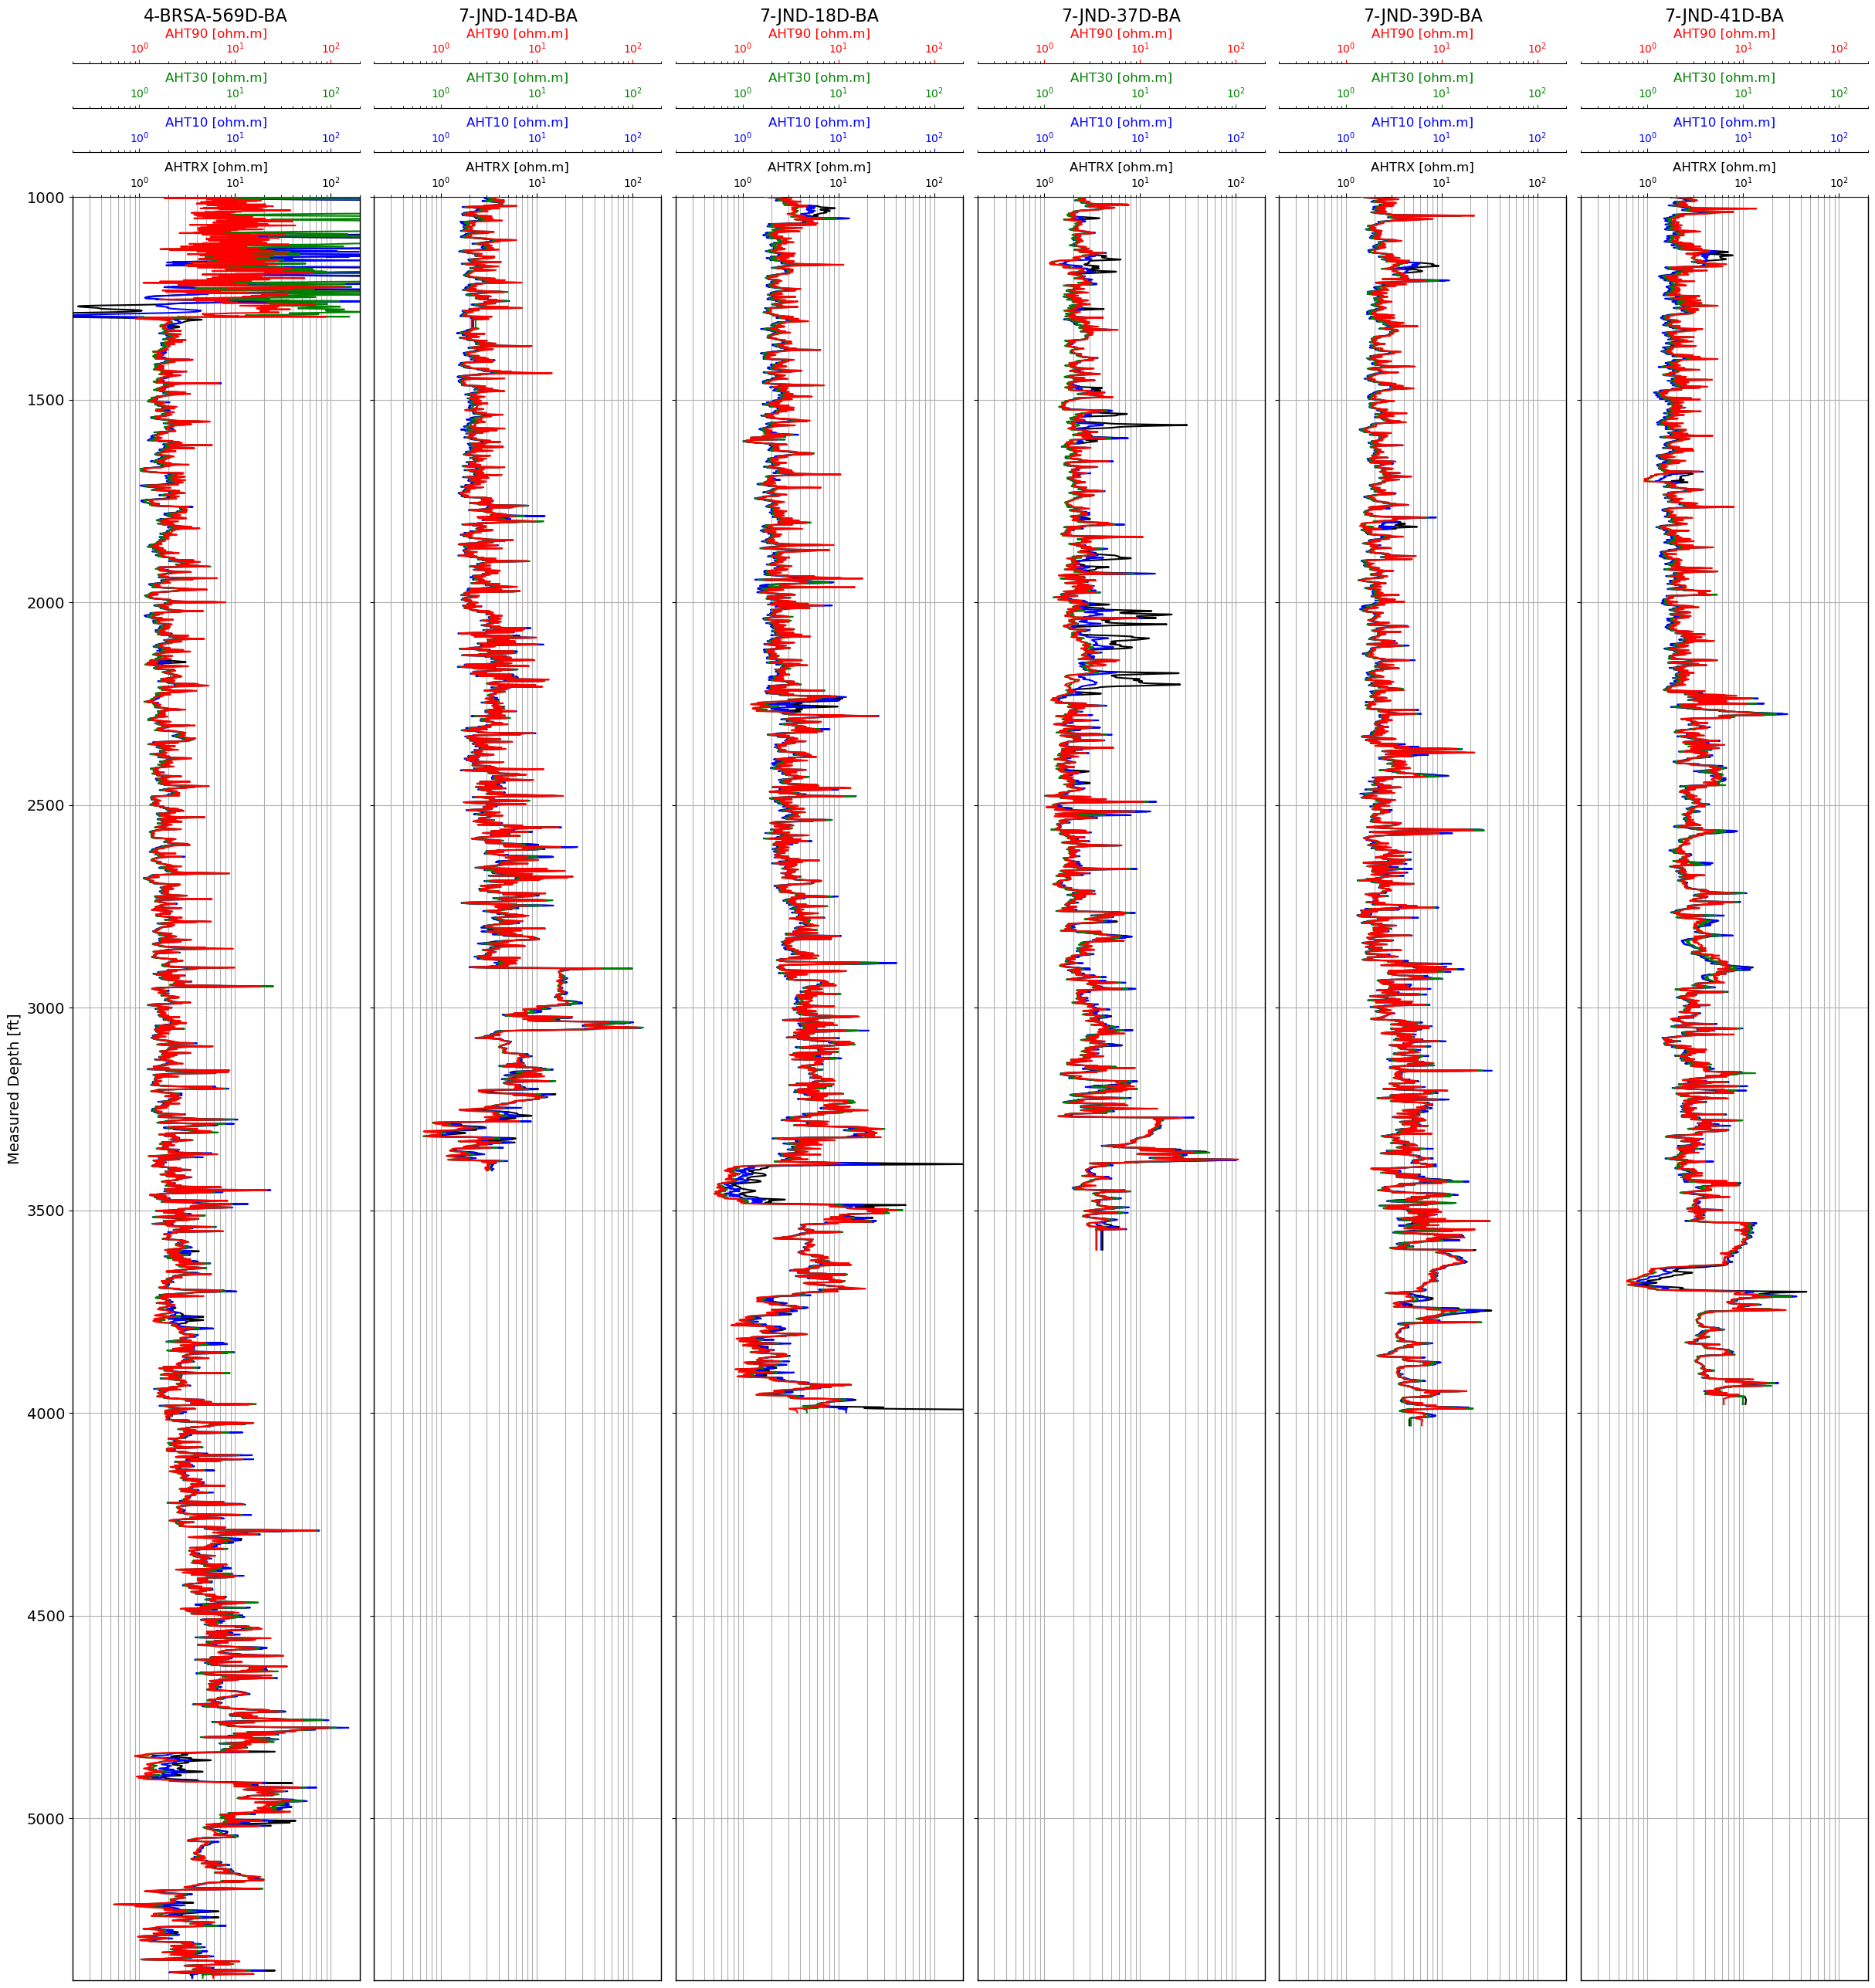

In [14]:
fig, axs = plt.subplots(figsize=(30,30),sharey=True)

ax1 = plt.subplot2grid((1,6),(0,0),rowspan=1,colspan=1)
ax7 = ax1.twiny()
ax8 = ax1.twiny()
ax9 = ax1.twiny()
ax2 = plt.subplot2grid((1,6),(0,1),rowspan=1,colspan=1)
ax10 = ax2.twiny()
ax11 = ax2.twiny()
ax12 = ax2.twiny()
ax3 = plt.subplot2grid((1,6),(0,2),rowspan=1,colspan=1)
ax13 = ax3.twiny()
ax14 = ax3.twiny()
ax15 = ax3.twiny()
ax4 = plt.subplot2grid((1,6),(0,3),rowspan=1,colspan=1)
ax16 = ax4.twiny()
ax17 = ax4.twiny()
ax18 = ax4.twiny()
ax5 = plt.subplot2grid((1,6),(0,4),rowspan=1,colspan=1)
ax19 = ax5.twiny()
ax20 = ax5.twiny()
ax21 = ax5.twiny()
ax6 = plt.subplot2grid((1,6),(0,5),rowspan=1,colspan=1)
ax22 = ax6.twiny()
ax23 = ax6.twiny()
ax24 = ax6.twiny()

Df_1 = Dfs[0]
Df_2 = Dfs[1]
Df_3 = Dfs[2]
Df_4 = Dfs[3]
Df_5 = Dfs[4]
Df_6 = Dfs[5]

ax1.plot("AHTRX","DEPTH",data=Df_1,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_title("4-BRSA-569D-BA",fontsize=16)

ax7.plot("AHT10","DEPTH",data=Df_1,color="blue")
ax7.set_xlim(0.2,200)
ax7.semilogx()
ax7.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax7.tick_params(axis="x",colors="blue")

ax8.plot("AHT30","DEPTH",data=Df_1,color="green")
ax8.set_xlim(0.2,200)
ax8.semilogx()
ax8.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax8.tick_params(axis="x",colors="green")

ax9.plot("AHT90","DEPTH",data=Df_1,color="red")
ax9.set_xlim(0.2,200)
ax9.semilogx()
ax9.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax9.tick_params(axis="x",colors="red")

ax2.plot("AHTRX","DEPTH",data=Df_2,color="black")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.grid(which="minor")
ax2.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax2.tick_params(axis="x",colors="black")
ax2.set_title("7-JND-14D-BA",fontsize=16)

ax10.plot("AHT10","DEPTH",data=Df_2,color="blue")
ax10.set_xlim(0.2,200)
ax10.semilogx()
ax10.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax10.tick_params(axis="x",colors="blue")

ax11.plot("AHT30","DEPTH",data=Df_2,color="green")
ax11.set_xlim(0.2,200)
ax11.semilogx()
ax11.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax11.tick_params(axis="x",colors="green")

ax12.plot("AHT90","DEPTH",data=Df_2,color="red")
ax12.set_xlim(0.2,200)
ax12.semilogx()
ax12.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax12.tick_params(axis="x",colors="red")

ax3.plot("AHTRX","DEPTH",data=Df_3,color="black")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.grid(which="minor")
ax3.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax3.tick_params(axis="x",colors="black")
ax3.set_title("7-JND-18D-BA",fontsize=16)

ax13.plot("AHT10","DEPTH",data=Df_3,color="blue")
ax13.set_xlim(0.2,200)
ax13.semilogx()
ax13.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax13.tick_params(axis="x",colors="blue")

ax14.plot("AHT30","DEPTH",data=Df_3,color="green")
ax14.set_xlim(0.2,200)
ax14.semilogx()
ax14.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax14.tick_params(axis="x",colors="green")

ax15.plot("AHT90","DEPTH",data=Df_3,color="red")
ax15.set_xlim(0.2,200)
ax15.semilogx()
ax15.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax15.tick_params(axis="x",colors="red")

ax4.plot("AHTRX","DEPTH",data=Df_4,color="black")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.grid(which="minor")
ax4.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax4.tick_params(axis="x",colors="black")
ax4.set_title("7-JND-37D-BA",fontsize=16)

ax16.plot("AHT10","DEPTH",data=Df_4,color="blue")
ax16.set_xlim(0.2,200)
ax16.semilogx()
ax16.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax16.tick_params(axis="x",colors="blue")

ax17.plot("AHT30","DEPTH",data=Df_4,color="green")
ax17.set_xlim(0.2,200)
ax17.semilogx()
ax17.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax17.tick_params(axis="x",colors="green")

ax18.plot("AHT90","DEPTH",data=Df_4,color="red")
ax18.set_xlim(0.2,200)
ax18.semilogx()
ax18.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax18.tick_params(axis="x",colors="red")

ax5.plot("AHTRX","DEPTH",data=Df_5,color="black")
ax5.set_xlim(0.2,200)
ax5.semilogx()
ax5.grid(which="minor")
ax5.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")
ax5.set_title("7-JND-39D-BA",fontsize=16)

ax19.plot("AHT10","DEPTH",data=Df_5,color="blue")
ax19.set_xlim(0.2,200)
ax19.semilogx()
ax19.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax19.tick_params(axis="x",colors="blue")

ax20.plot("AHT30","DEPTH",data=Df_5,color="green")
ax20.set_xlim(0.2,200)
ax20.semilogx()
ax20.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax20.tick_params(axis="x",colors="green")

ax21.plot("AHT90","DEPTH",data=Df_5,color="red")
ax21.set_xlim(0.2,200)
ax21.semilogx()
ax21.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax21.tick_params(axis="x",colors="red")

ax6.plot("AHTRX","DEPTH",data=Df_6,color="black")
ax6.set_xlim(0.2,200)
ax6.semilogx()
ax6.grid(which="minor")
ax6.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax6.tick_params(axis="x",colors="black")
ax6.set_title("7-JND-41D-BA",fontsize=16)

ax22.plot("AHT10","DEPTH",data=Df_6,color="blue")
ax22.set_xlim(0.2,200)
ax22.semilogx()
ax22.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax22.tick_params(axis="x",colors="blue")

ax23.plot("AHT30","DEPTH",data=Df_6,color="green")
ax23.set_xlim(0.2,200)
ax23.semilogx()
ax23.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax23.tick_params(axis="x",colors="green")

ax24.plot("AHT90","DEPTH",data=Df_6,color="red")
ax24.set_xlim(0.2,200)
ax24.semilogx()
ax24.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax24.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(5400,1000)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5 or i==9 or i==13 or i==17 or i==21:
        ax.spines["top"].set_position(("axes",1.025))
    elif i==2 or i==6 or i==10 or i==14 or i==18 or i==22:
        ax.spines["top"].set_position(("axes",1.05))
    elif i==3 or i==7 or i==11 or i==15 or i==19 or i==23:
        ax.spines["top"].set_position(("axes",1.075))
    else:
        ax.grid()


for ax in [ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# Modelos Di

In [15]:
#Crear Diametro Crain
for i in range(0,len(Dfs)):
    df = Dfs[i]
    df["RESDc"] = ""
    df["Di_Crain"] = ""
    for j in range(0,len(df["DEPTH"])):
        df.iloc[j,9] = Correccion_Crain(df.iloc[j,6],df.iloc[j,8],df.iloc[j,5])
        df.iloc[j,10] = Invasion_Crain(df.iloc[j,6],df.iloc[j,8],df.iloc[j,9])
    df["RESDc"] = df.RESDc.astype(float)
    df["Di_Crain"] = df.Di_Crain.astype(float)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:15: RuntimeWarning: invalid value encountered in scalar divide
  C =(RESM/RESDc)*(RESD-RESDc)/(RESM-RESD)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:16: RuntimeWarning: overflow encountered in scalar power
  Di = 33*(C+1)-min(100,10**(0.5*C-0.04))
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:15: RuntimeWarning: invalid value encountered in scalar divide
  C =(RESM/RESDc)*(RESD-RESDc)/(RESM-RESD)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:16: RuntimeWarning: overflow encountered in scalar power
  Di = 33*(C+1)-min(100,10**(0.5*C-0.04))
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:16: RuntimeWarning: overflow encountered in scalar power
  Di = 33*(C+1)-min(100,10**(0.5*C-0.04))
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2836582955.py:16: RuntimeWarning: overflow encountered in scalar power
  Di = 33*(C+1)-min(100,10**(0.5*C-0.04))
C:\Users\HOME\AppDat

In [16]:
#Crear Diametro Propuesto
for i in range(0,len(Dfs)):
    df = Dfs[i]
    df["Rxo_Rd"] = ""
    df["Rxo_Rs"] = ""
    df["Alpha"] = ""
    df["Di_Mauro"] = ""
    for j in range(0,len(df["DEPTH"])):
        df.iloc[j,11] = Rxo_Rd(df.iloc[j,4],df.iloc[j,6])
        df.iloc[j,12] = Rxo_Rs(df.iloc[j,4],df.iloc[j,5])
        df.iloc[j,13] = alpha(df.iloc[j,5],df.iloc[j,6],df.iloc[j,4])
        df.iloc[j,14] = Di_Mauro(df.iloc[j,13],df.iloc[j,11],df.iloc[j,12])
    df["Rxo_Rd"] = df.Rxo_Rd.astype(float)
    df["Rxo_Rs"] = df.Rxo_Rs.astype(float)
    df["Alpha"] = df.Alpha.astype(float)
    df["Di_Mauro"] = df.Di_Mauro.astype(float)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: invalid value encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)
C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2743362986.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  division = (RSHAL-RDEEP)/(Rxo-RDEEP)


# 4-BRSA-569D-BA

## 3580 – 4000 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\3352258602.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


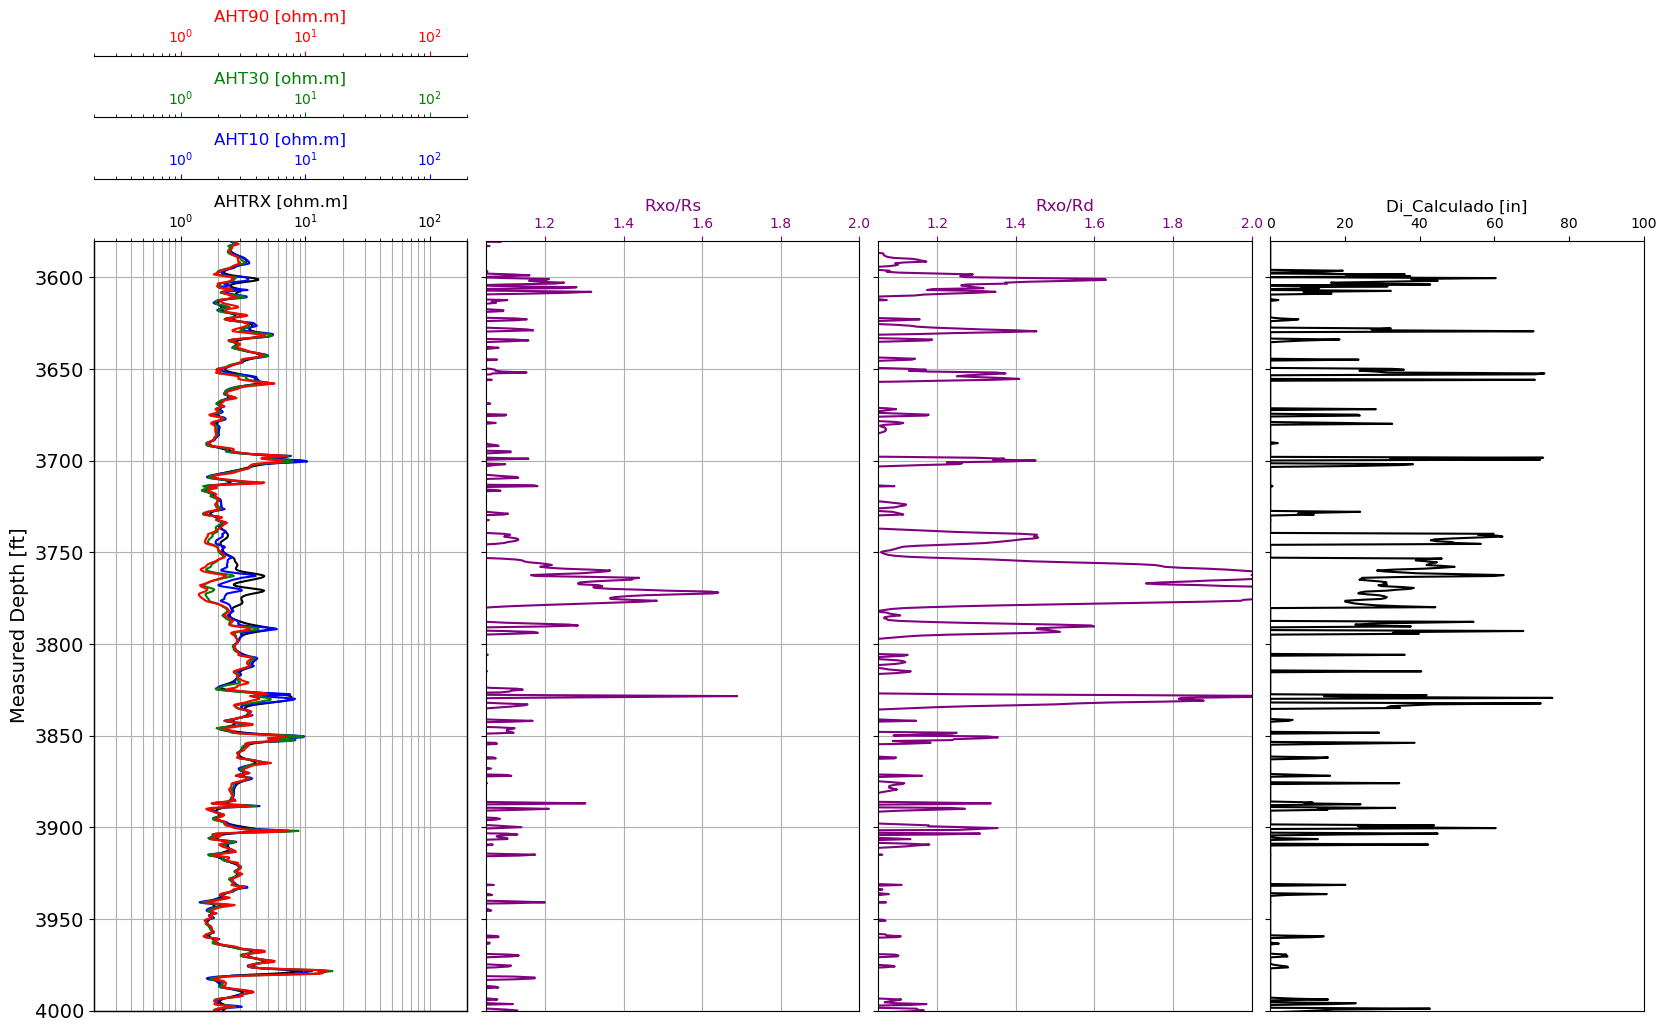

In [17]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_1,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_1,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_1,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_1,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_1,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_1,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_1,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(4000,3580)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2813829530.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


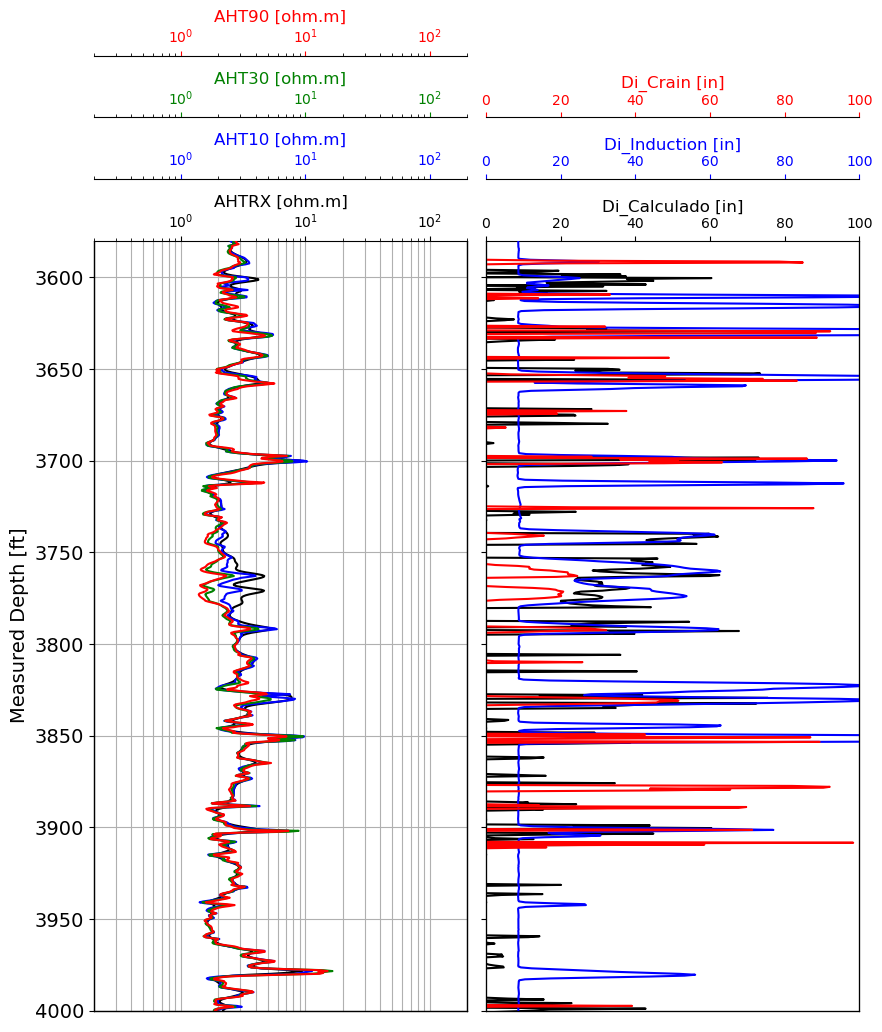

In [18]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_1,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_1,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_1,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_1,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_1,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_1,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_1,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(4000,3580)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()

ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)

for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

## 4660 - 5320 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\1104477323.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


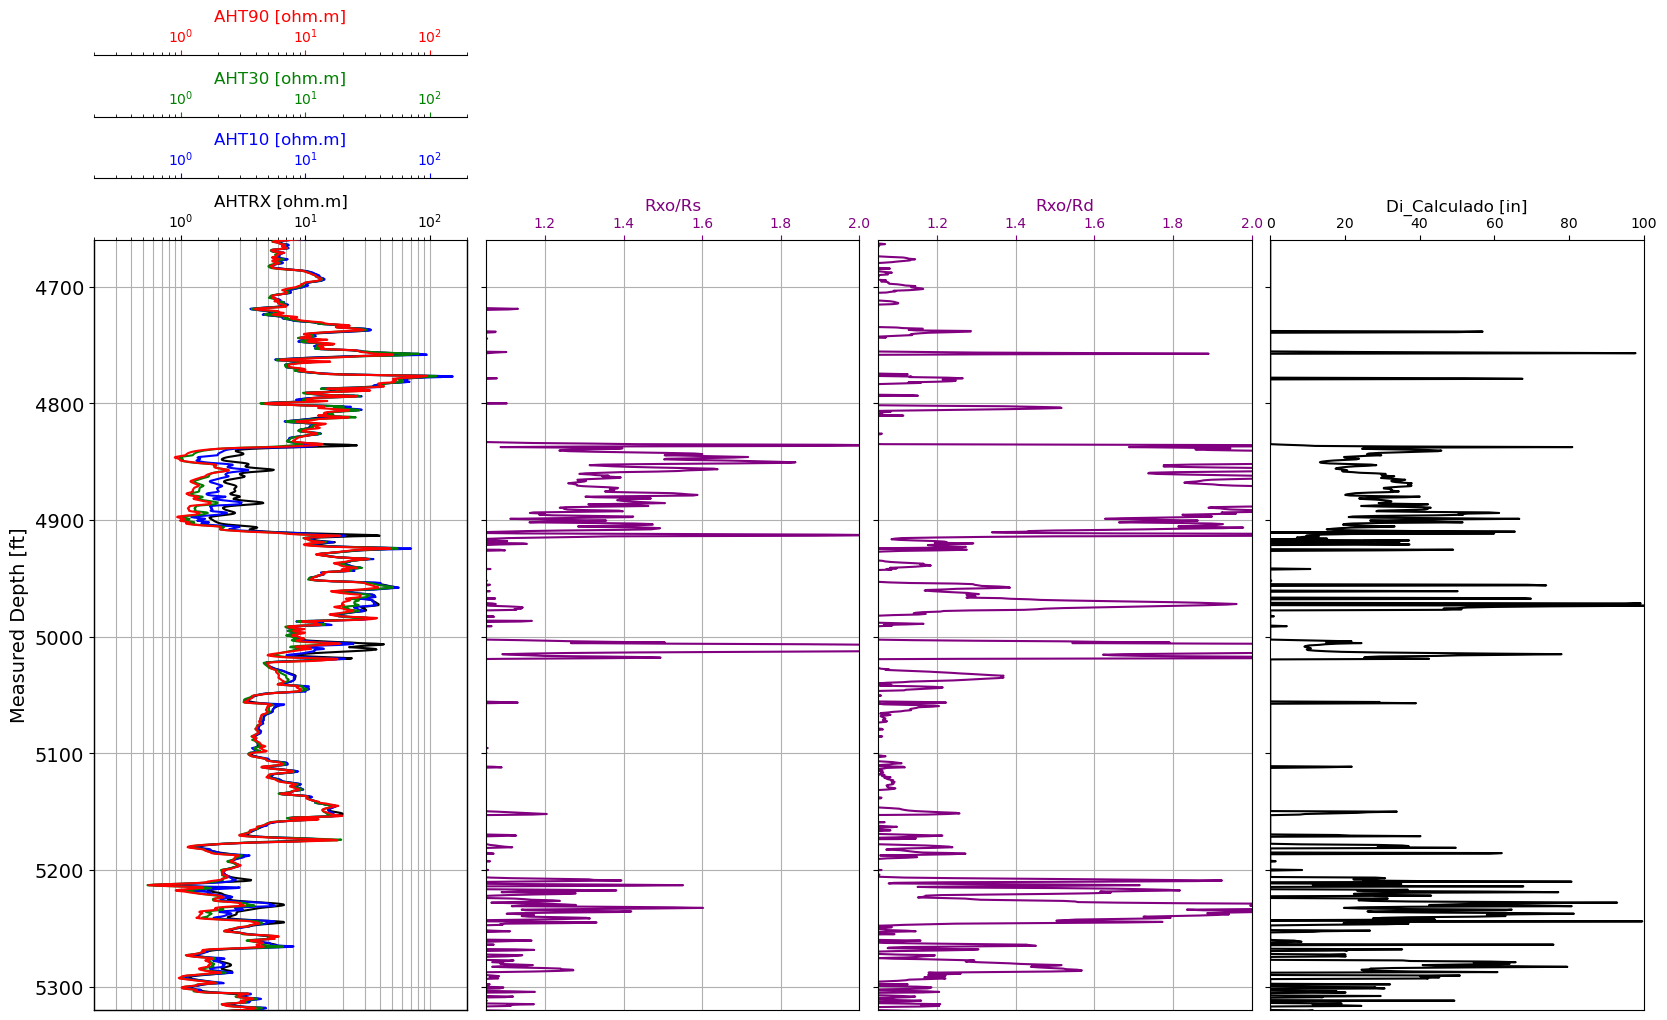

In [19]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_1,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_1,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_1,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_1,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_1,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_1,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_1,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(5320,4660)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()

ax7.grid(visible=False)

for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\1637633711.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


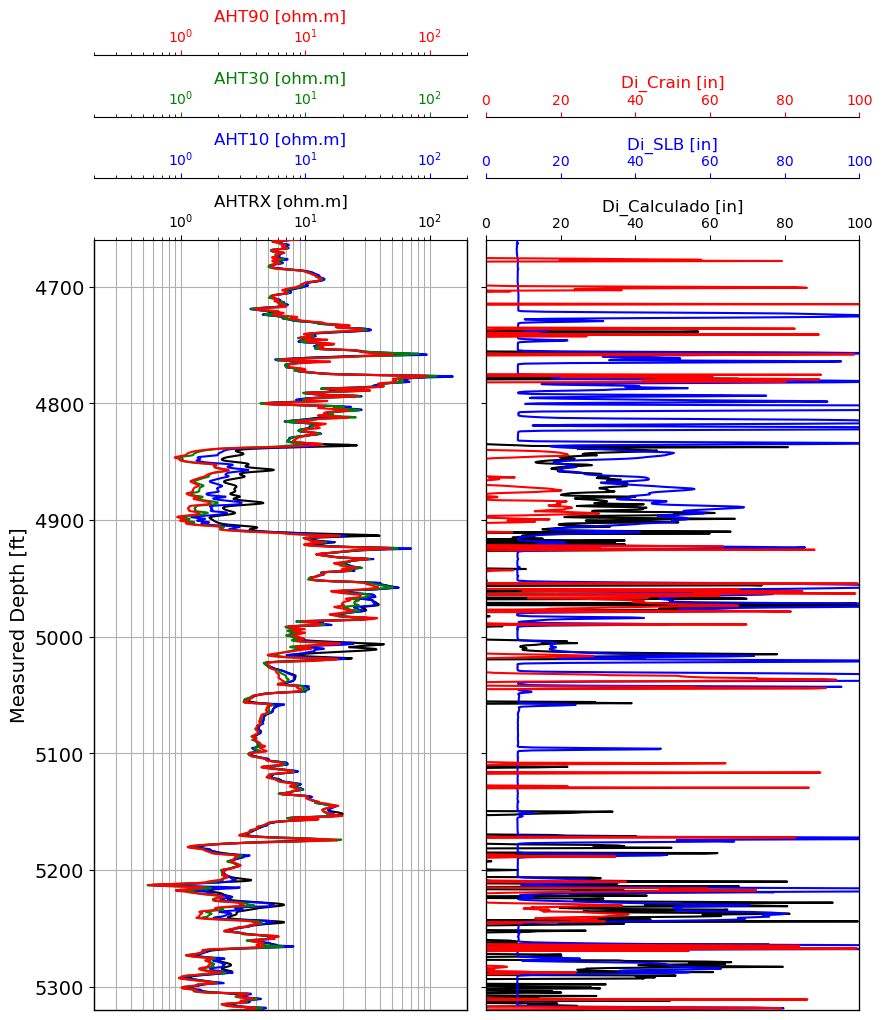

In [20]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_1,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_1,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_1,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_1,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_1,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_1,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_SLB [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_1,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(5320,4660)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()

ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# 7JND-14D-BA

## 3180 - 3380 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\3625487332.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


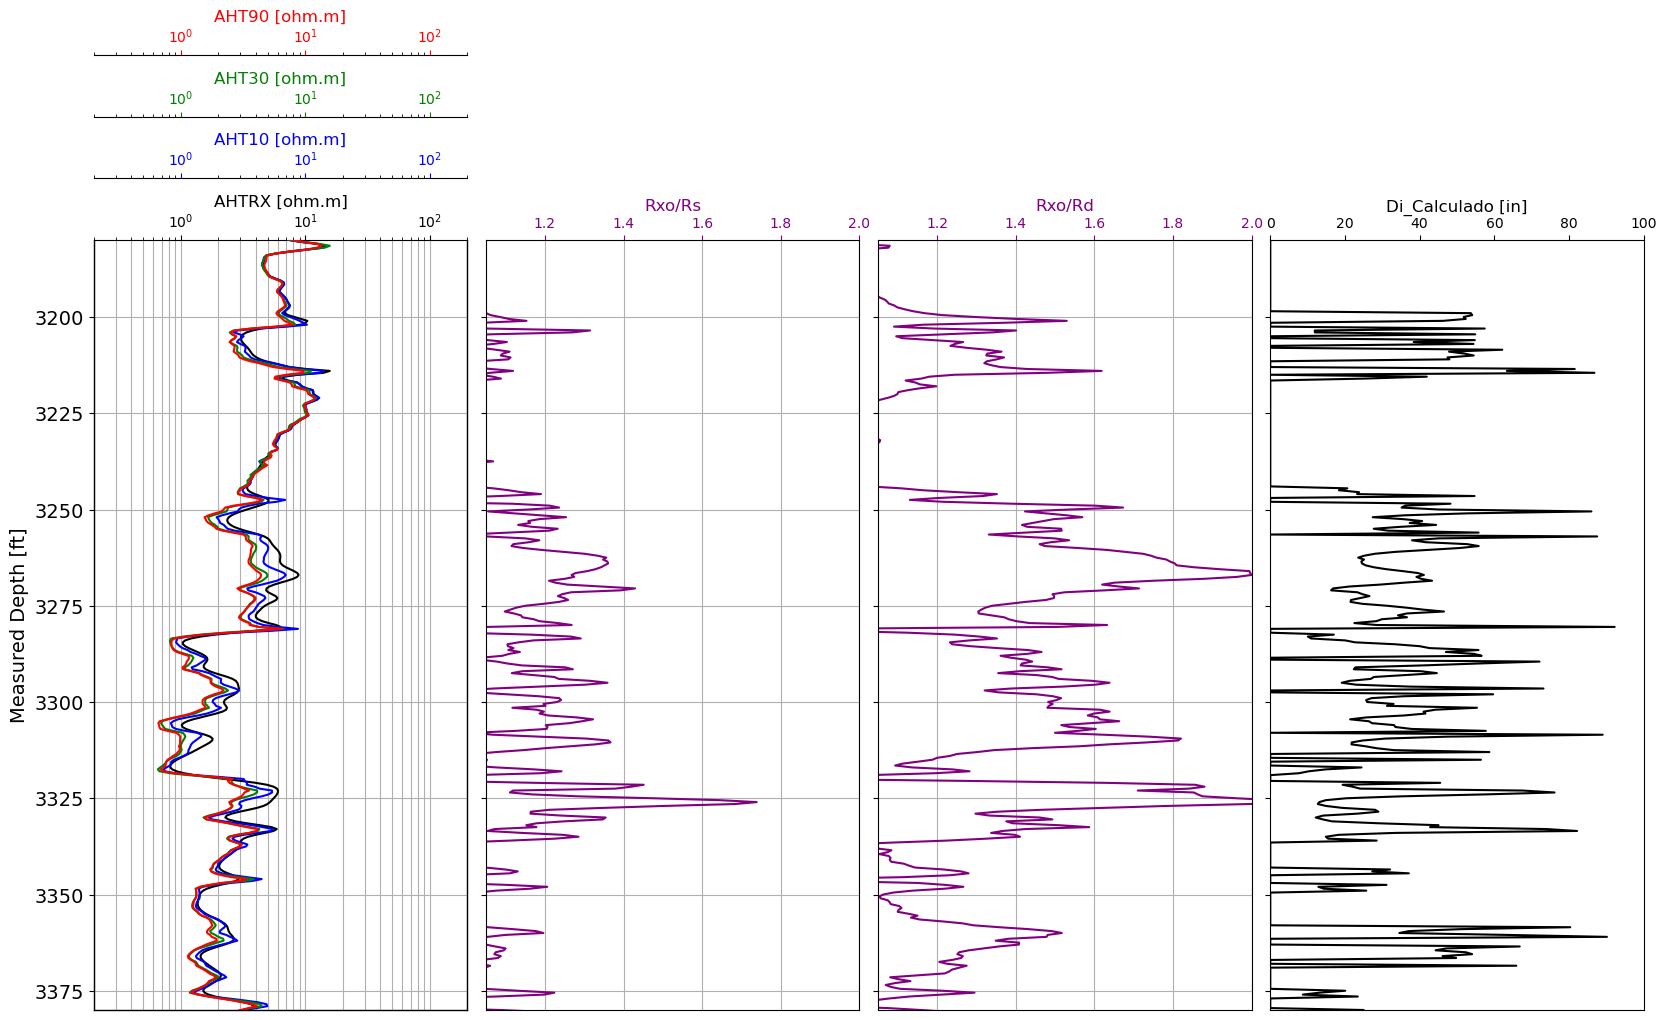

In [21]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_2,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_2,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_2,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_2,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_2,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_2,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_2,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3380,3180)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\1560589574.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


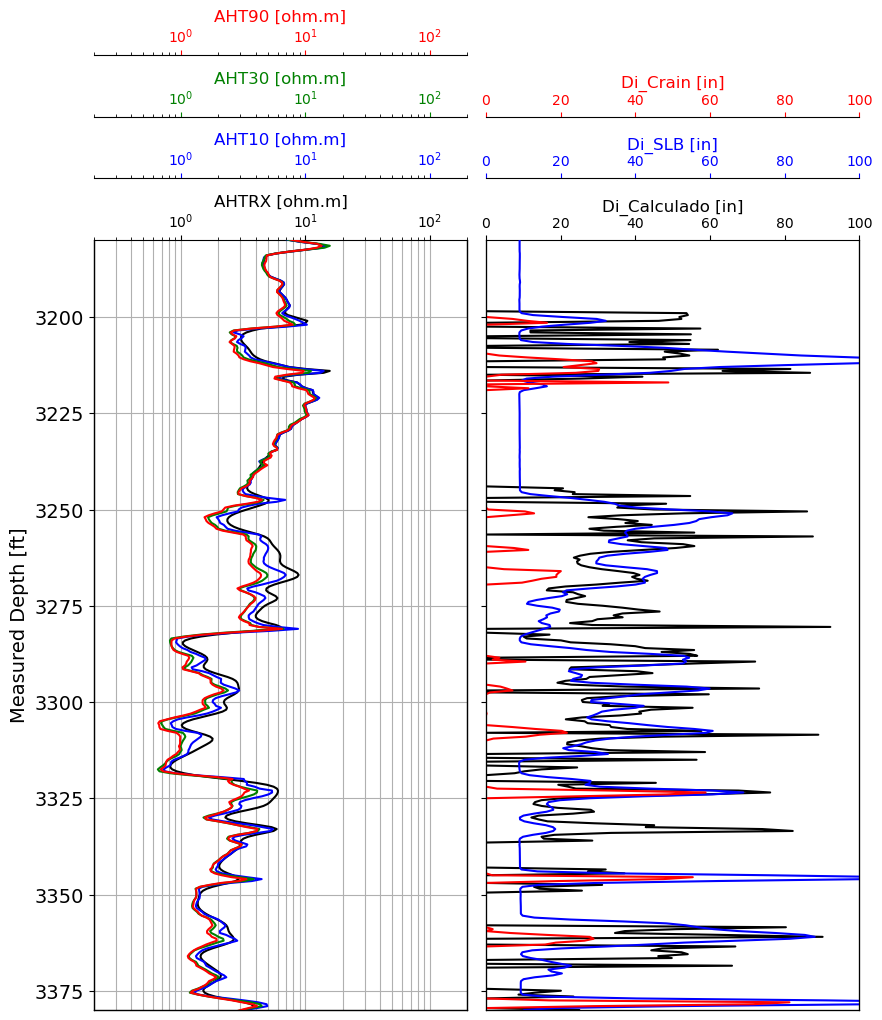

In [22]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_2,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_2,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_2,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_2,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_2,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_2,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_SLB [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_2,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3380,3180)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# 7-JND-18D-BA

## 2200 - 2350 M

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\1864444651.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


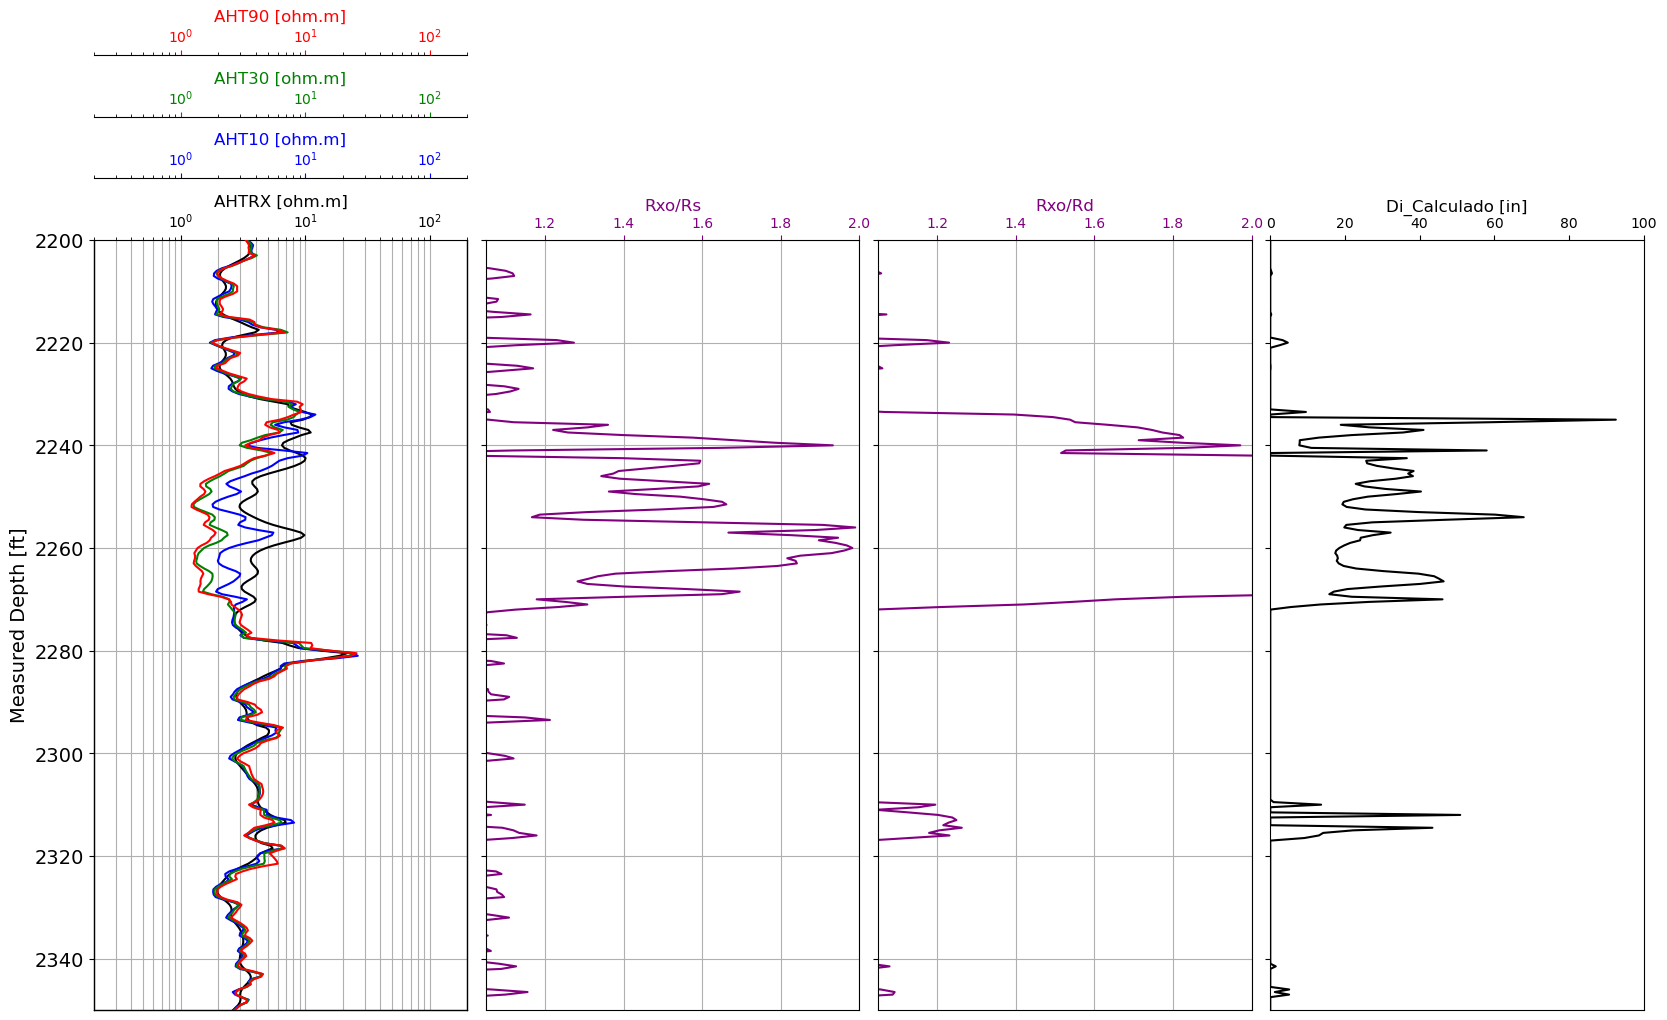

In [23]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_3,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_3,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_3,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_3,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_3,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_3,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_3,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(2350,2200)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\768271612.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


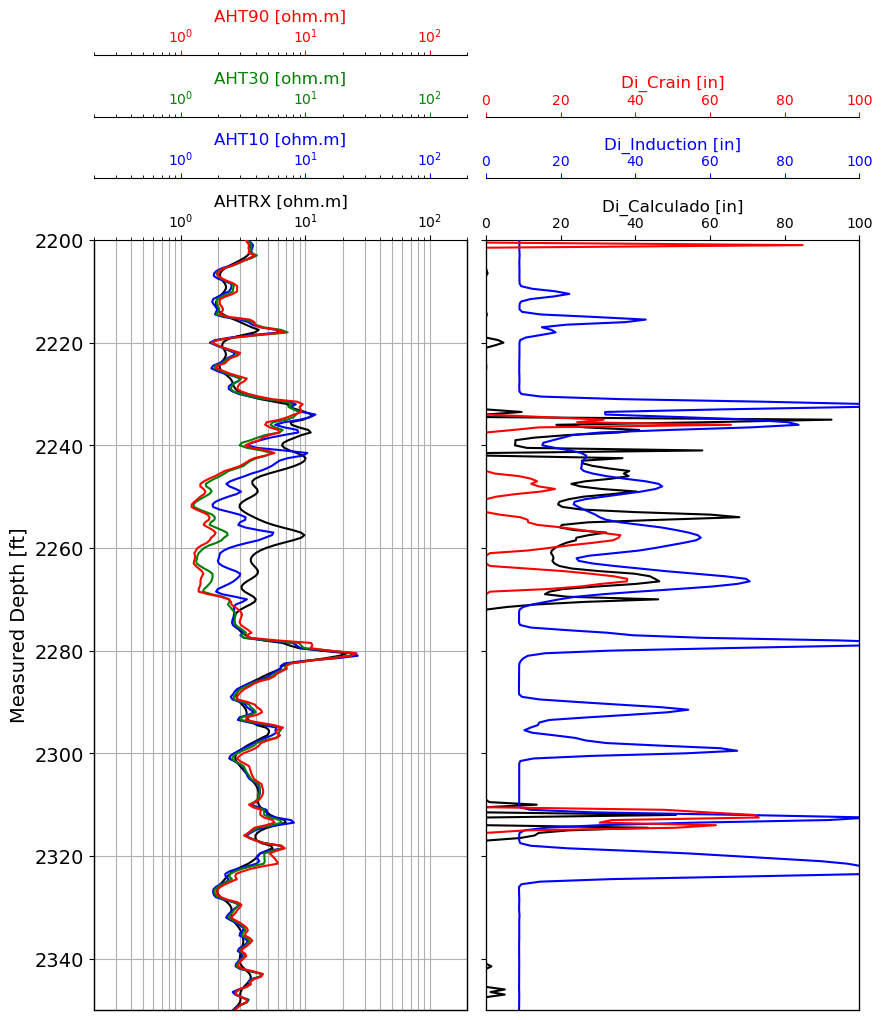

In [24]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_3,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_3,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_3,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_3,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_3,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_3,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_3,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(2350,2200)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# 7-JND-37D-BA

## 1120 - 1220 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\661091231.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


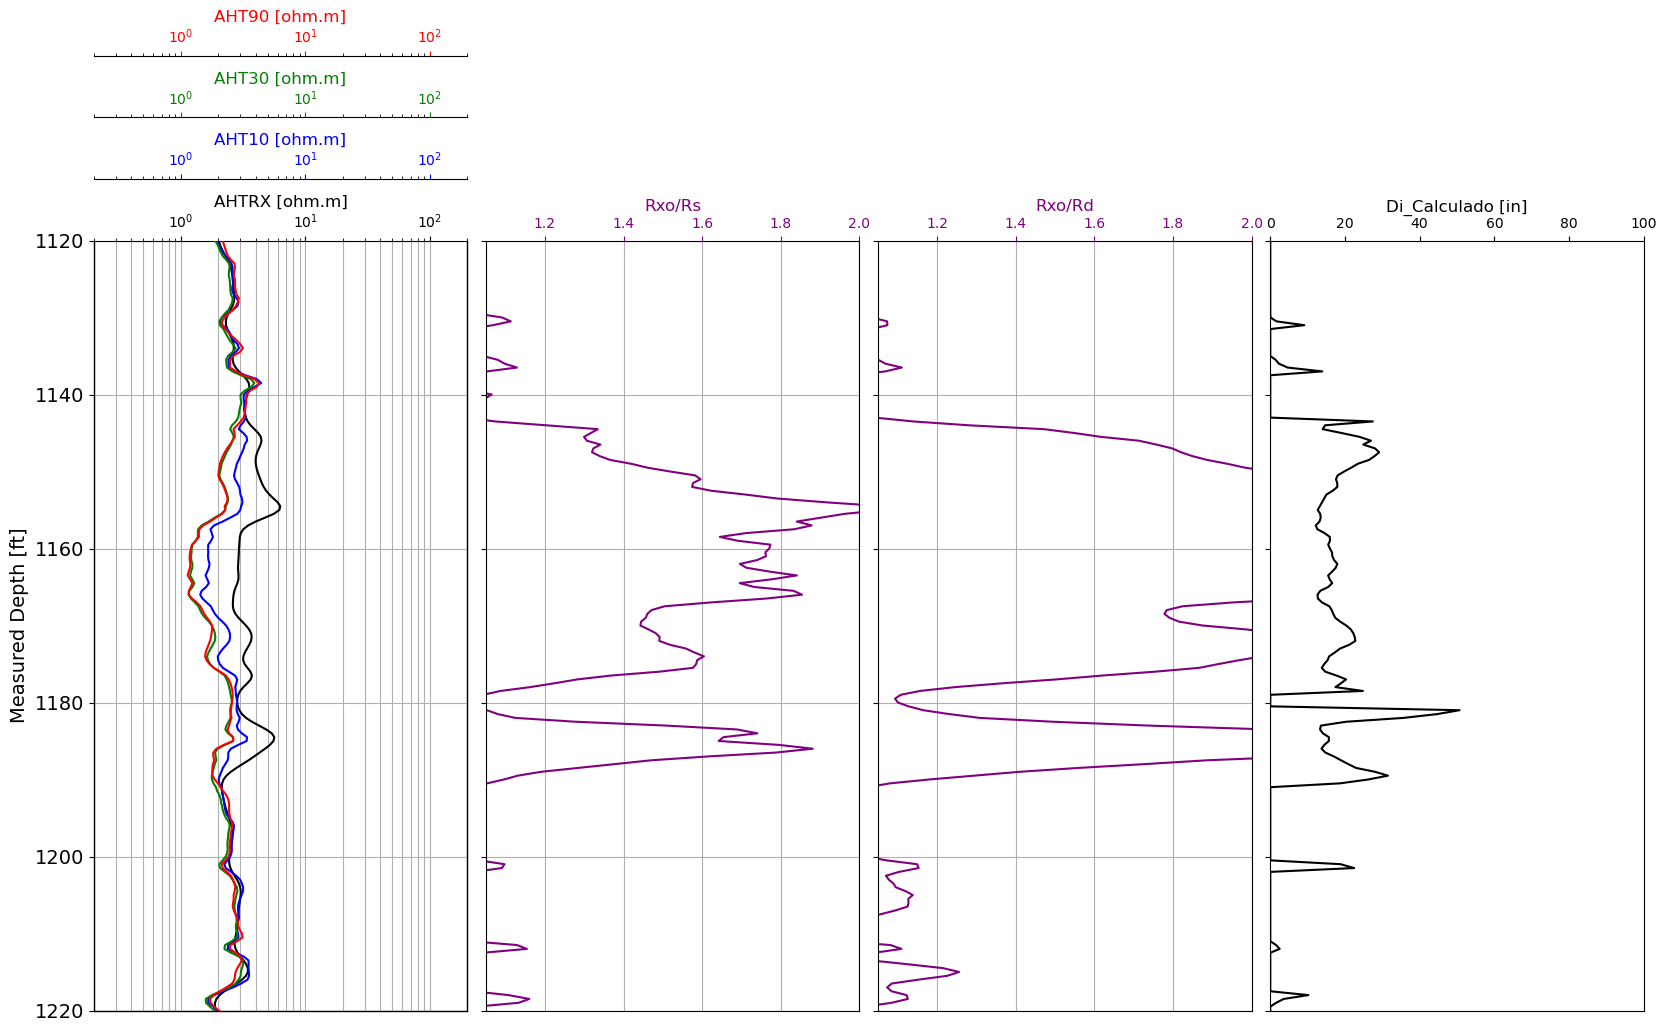

In [25]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_4,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_4,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_4,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_4,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_4,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_4,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_4,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(1220,1120)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2143188881.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


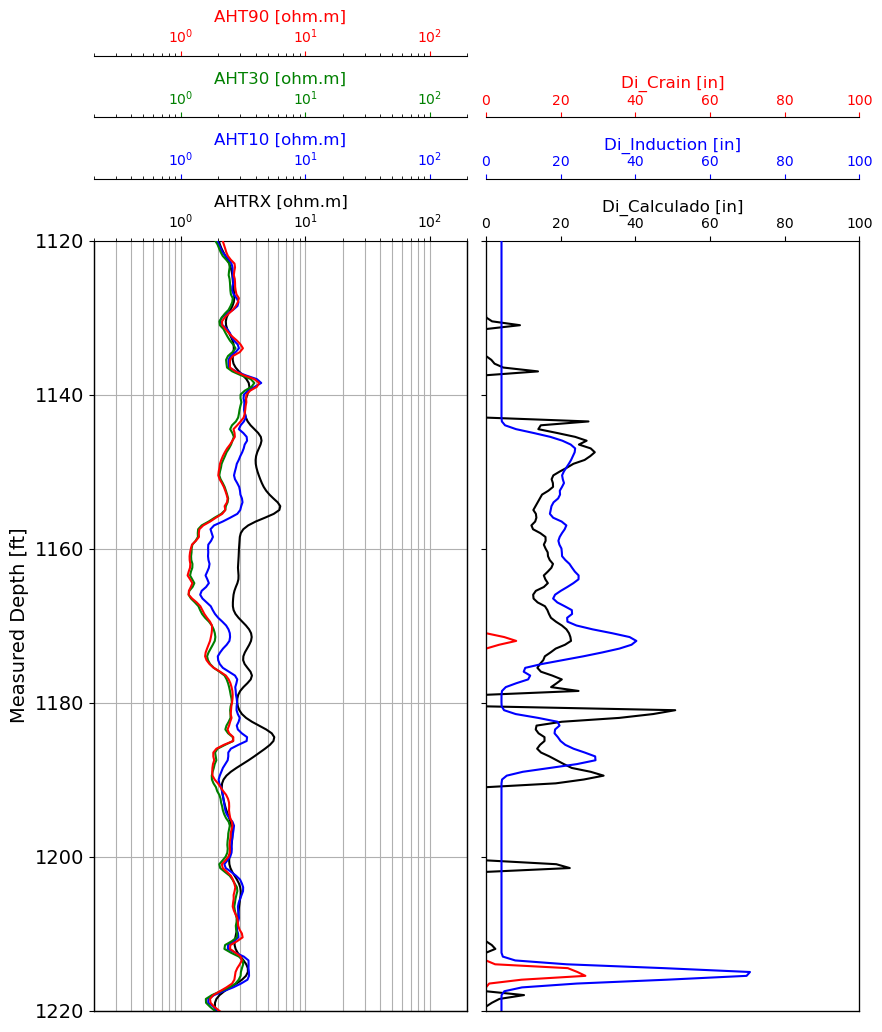

In [26]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_4,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_4,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_4,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_4,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_4,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_4,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_4,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(1220,1120)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

## 1860 - 2260 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\851346945.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


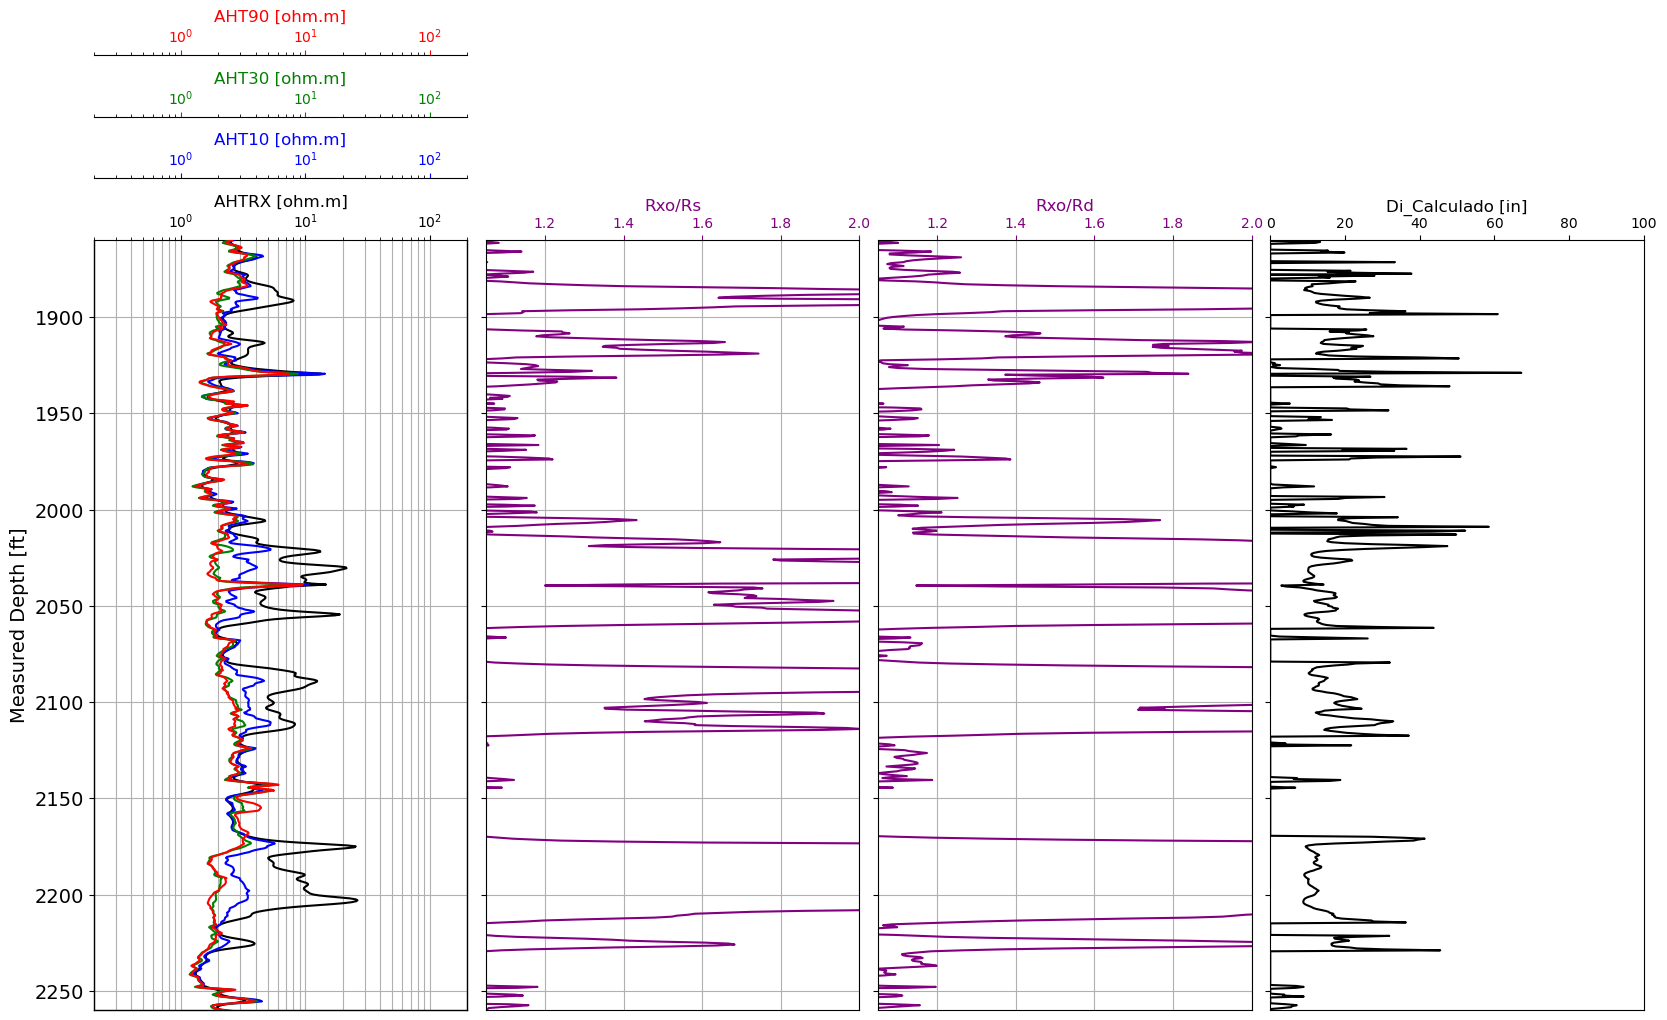

In [27]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_4,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_4,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_4,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_4,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_4,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_4,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_4,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(2260,1860)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2895301813.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


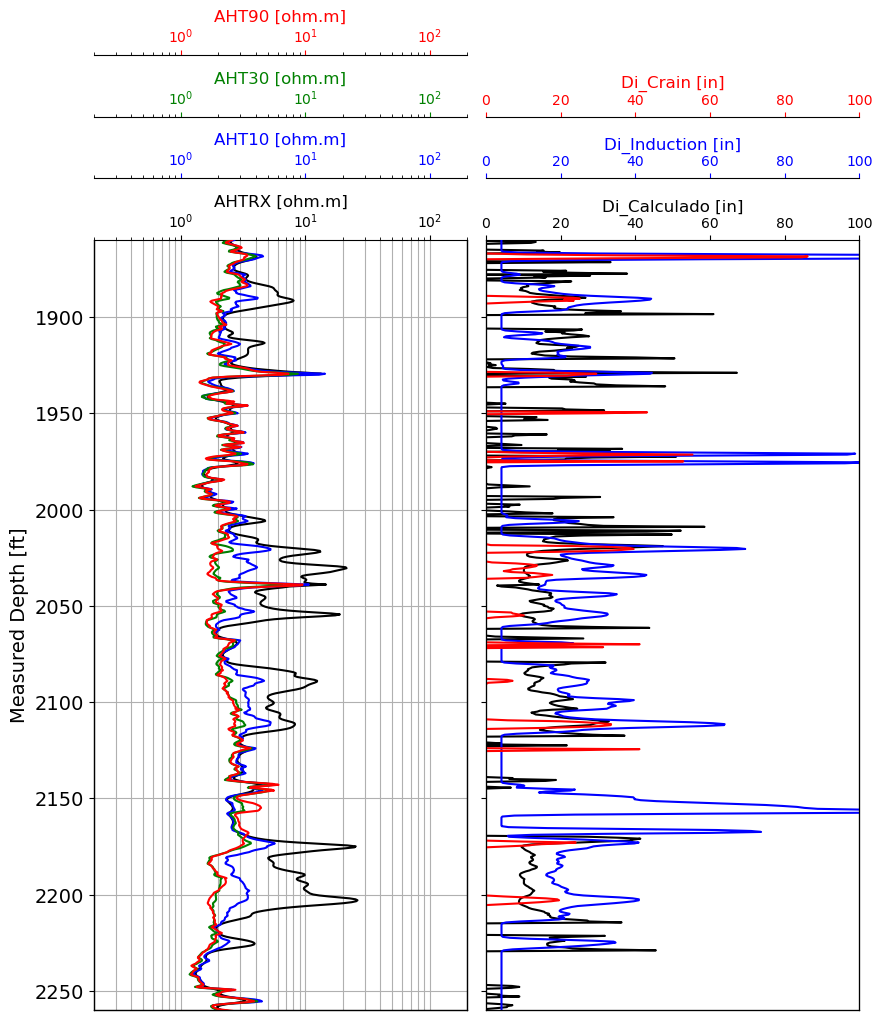

In [28]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_4,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_4,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_4,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_4,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_4,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_4,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_4,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(2260,1860)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# 7-JND-39D-BA

## 3593 - 3770 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\816850828.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


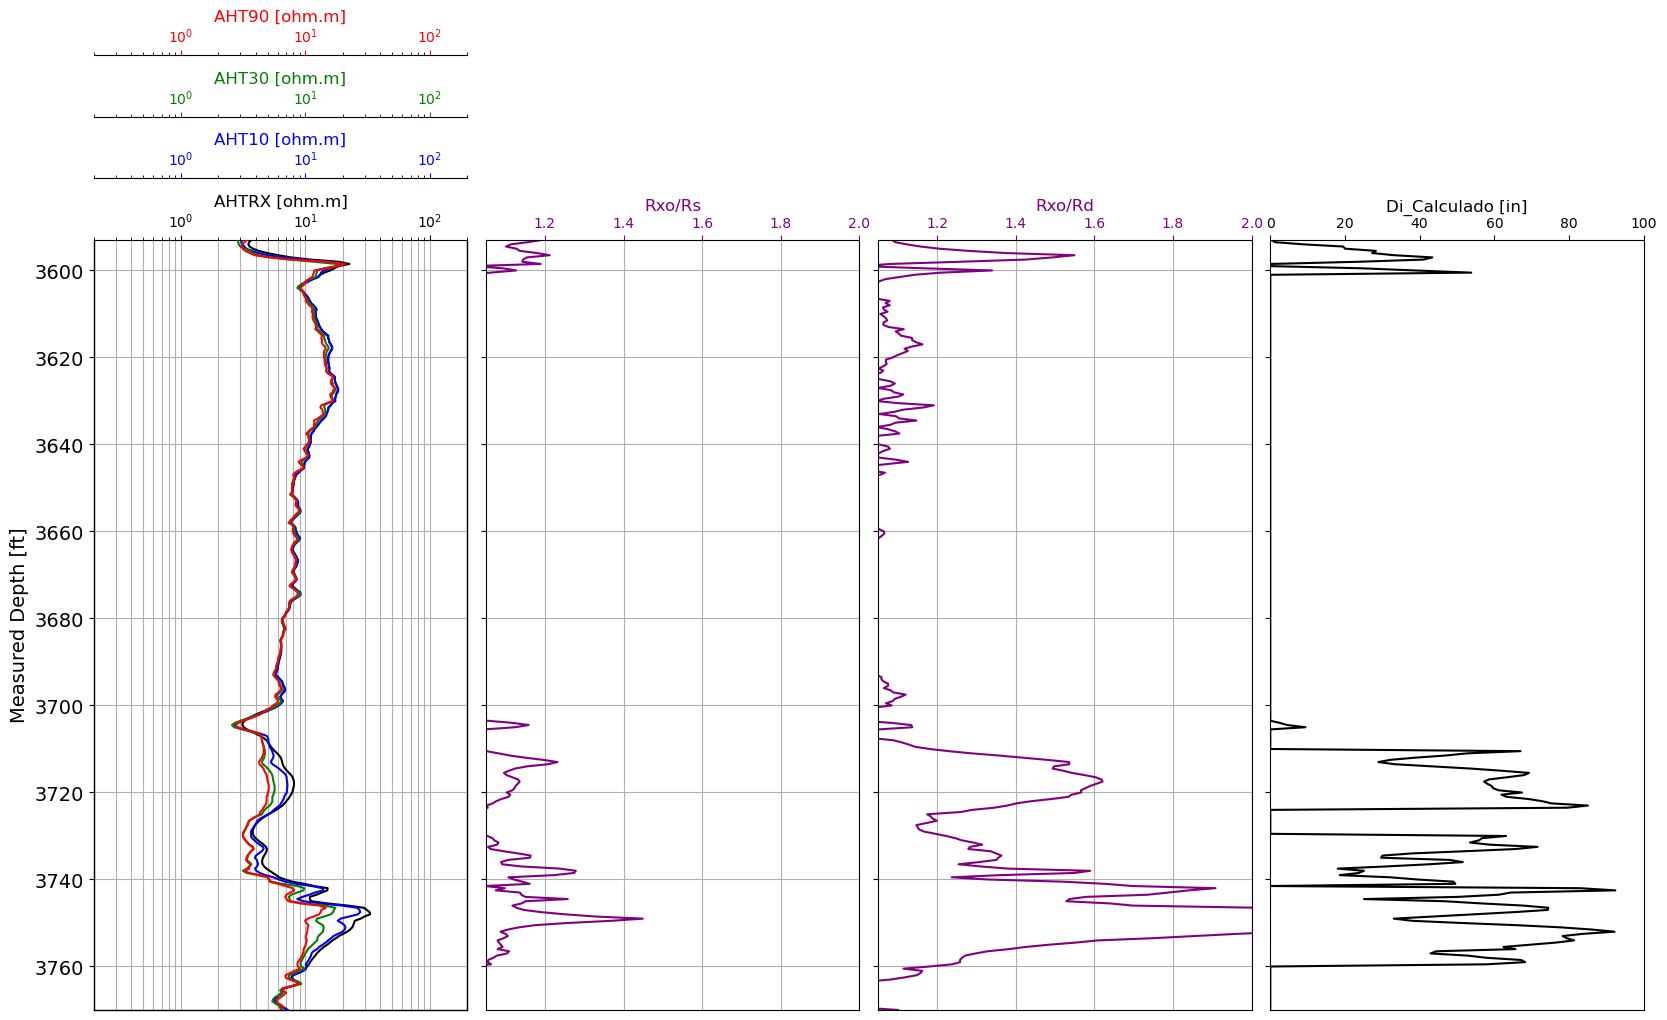

In [29]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_5,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_5,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_5,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_5,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_5,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_5,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_5,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3770,3593)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\857820555.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


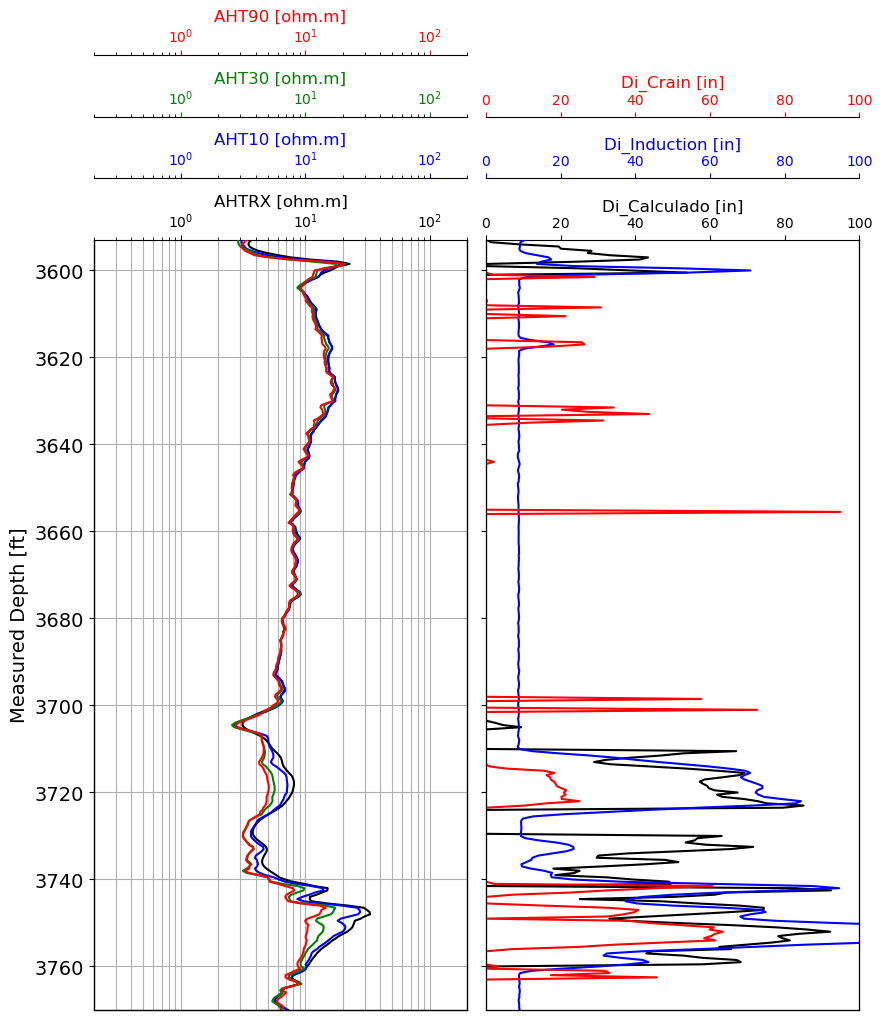

In [30]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_5,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_5,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_5,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_5,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_5,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_5,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_5,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3770,3593)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

# 7-JND-41D-BA

## 3506 - 3788 m

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\126676369.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


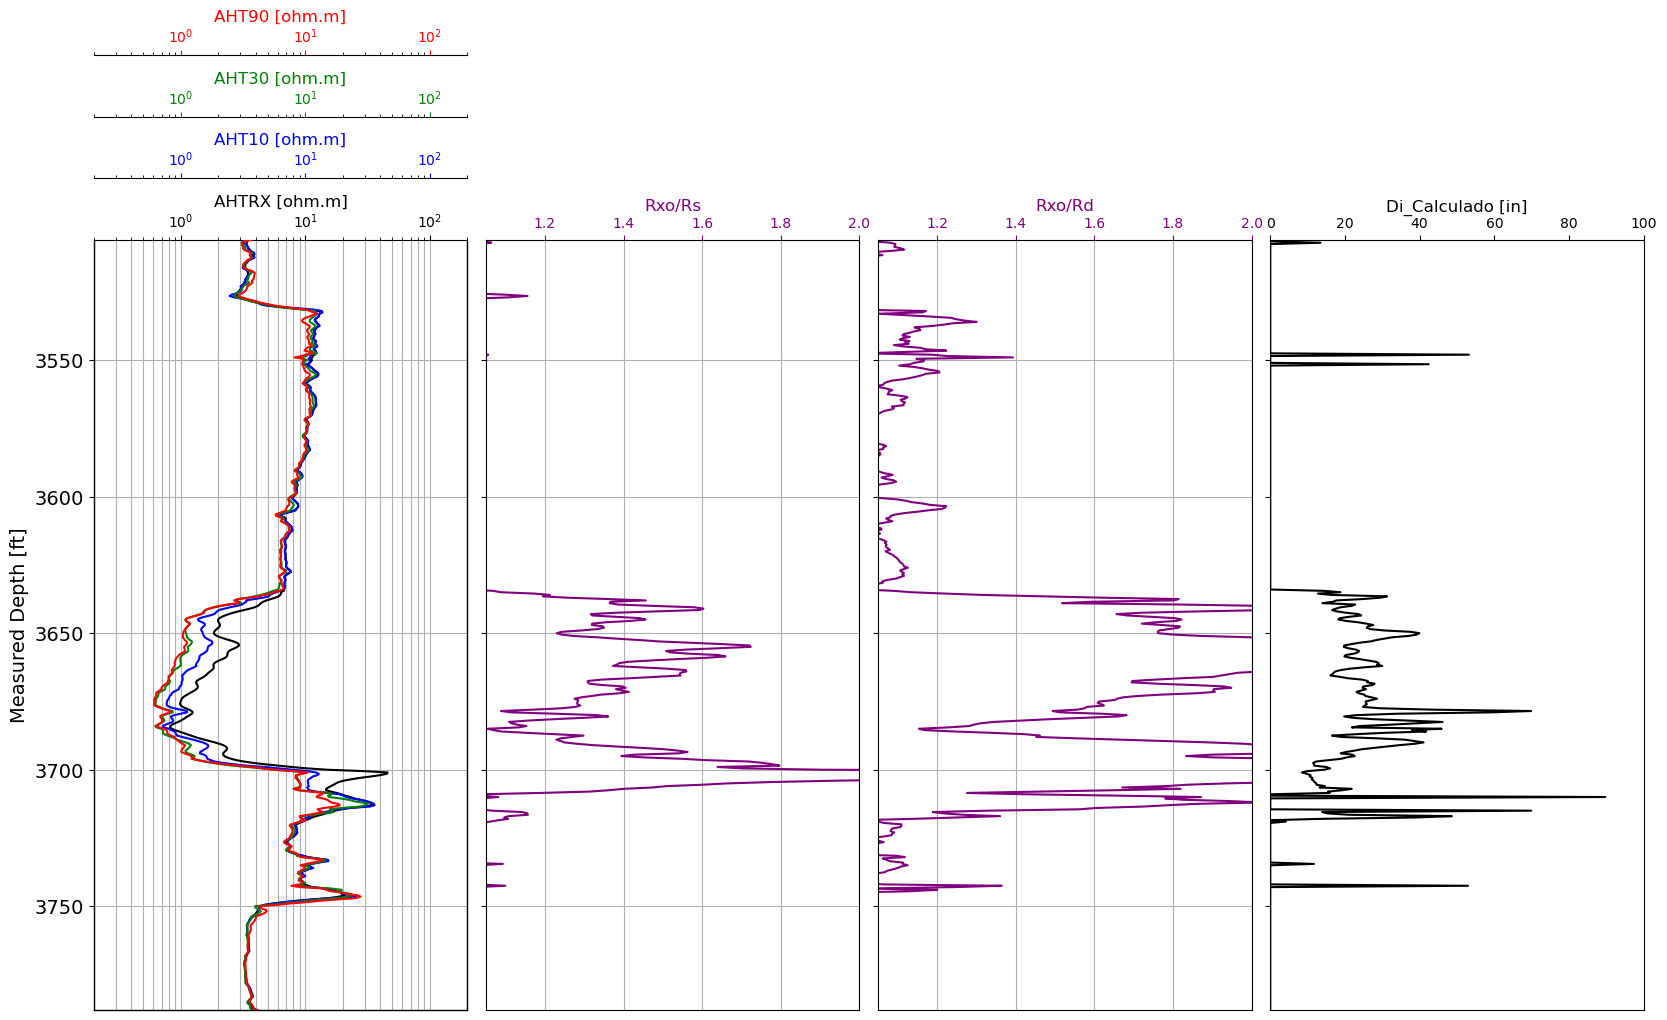

In [31]:
#CAP 3
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = plt.subplot2grid((1,4),(0,2),rowspan=1,colspan=1)
ax7 = plt.subplot2grid((1,4),(0,3),rowspan=1,colspan=1)

ax1.plot("AHTRX","DEPTH",data=Df_6,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_6,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_6,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_6,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Rxo_Rs","DEPTH",data=Df_6,color="purple")
ax5.set_xlim(1.05,2)
ax5.set_xlabel("Rxo/Rs",color="purple",fontsize=12)
ax5.tick_params(axis="x",colors="purple")

ax6.plot("Rxo_Rd","DEPTH",data=Df_6,color="purple")
ax6.set_xlim(1.05,2)
ax6.set_xlabel("Rxo/Rd",color="purple",fontsize=12)
ax6.tick_params(axis="x",colors="purple")

ax7.plot("Di_Mauro","DEPTH",data=Df_6,color="black")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax7.tick_params(axis="x",colors="black")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3788,3506)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)

C:\Users\HOME\AppData\Local\Temp\ipykernel_7608\2327510309.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)


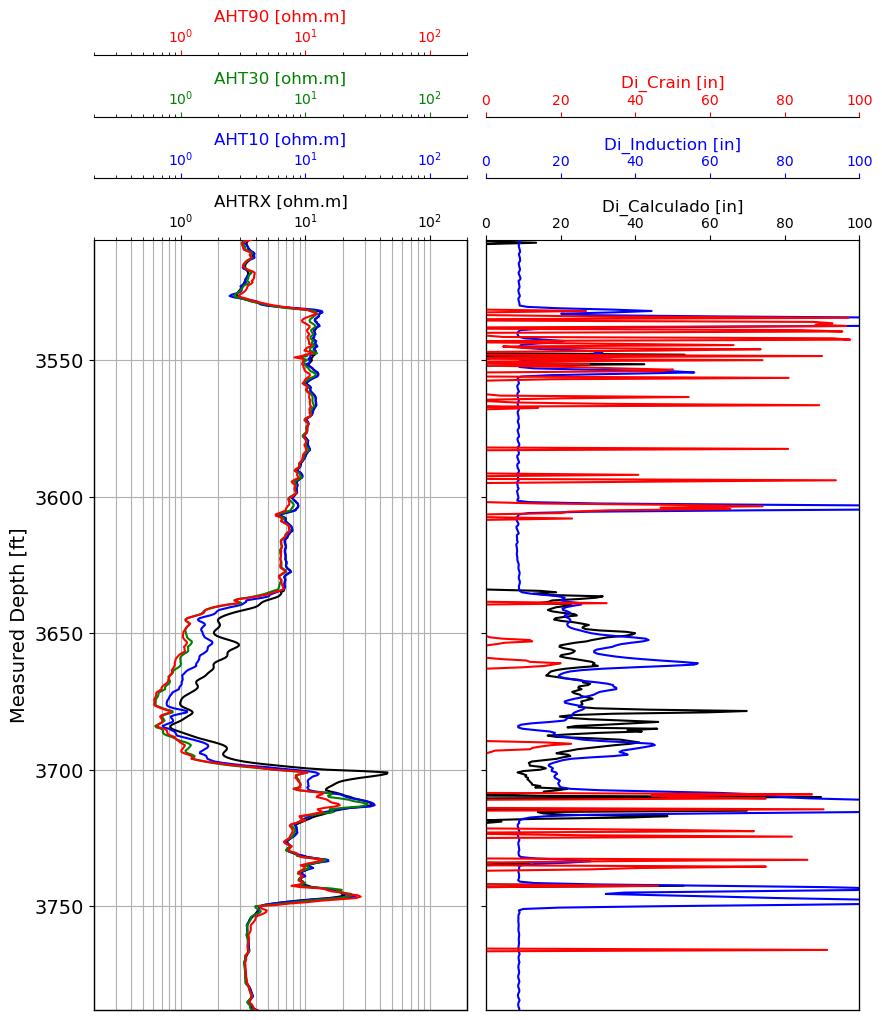

In [32]:
#CAP 4
fig, axs = plt.subplots(figsize=(20,10),sharey=True)

ax1 = plt.subplot2grid((1,4),(0,0),rowspan=1,colspan=1)
ax2 = ax1.twiny()
ax3 = ax1.twiny()
ax4 = ax1.twiny()
ax5 = plt.subplot2grid((1,4),(0,1),rowspan=1,colspan=1)
ax6 = ax5.twiny()
ax7 = ax5.twiny()

ax1.plot("AHTRX","DEPTH",data=Df_6,color="black")
ax1.set_xlim(0.2,200)
ax1.semilogx()
ax1.grid(which="minor")
ax1.set_xlabel("AHTRX [ohm.m]",color="black",fontsize=12)
ax1.tick_params(axis="x",colors="black")
ax1.set_ylabel("Measured Depth [ft]",color="black",fontsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2.plot("AHT10","DEPTH",data=Df_6,color="blue")
ax2.set_xlim(0.2,200)
ax2.semilogx()
ax2.set_xlabel("AHT10 [ohm.m]",color="blue",fontsize=12)
ax2.tick_params(axis="x",colors="blue")

ax3.plot("AHT30","DEPTH",data=Df_6,color="green")
ax3.set_xlim(0.2,200)
ax3.semilogx()
ax3.set_xlabel("AHT30 [ohm.m]",color="green",fontsize=12)
ax3.tick_params(axis="x",colors="green")

ax4.plot("AHT90","DEPTH",data=Df_6,color="red")
ax4.set_xlim(0.2,200)
ax4.semilogx()
ax4.set_xlabel("AHT90 [ohm.m]",color="red",fontsize=12)
ax4.tick_params(axis="x",colors="red")

ax5.plot("Di_Mauro","DEPTH",data=Df_6,color="black")
ax5.set_xlim(0,100)
ax5.set_xlabel("Di_Calculado [in]",color="black",fontsize=12)
ax5.tick_params(axis="x",colors="black")

ax6.plot("AHTD2","DEPTH",data=Df_6,color="blue")
ax6.set_xlim(0,100)
ax6.set_xlabel("Di_Induction [in]",color="blue",fontsize=12)
ax6.tick_params(axis="x",colors="blue")

ax7.plot("Di_Crain","DEPTH",data=Df_6,color="red")
ax7.set_xlim(0,100)
ax7.set_xlabel("Di_Crain [in]",color="red",fontsize=12)
ax7.tick_params(axis="x",colors="red")

for i, ax in enumerate(fig.axes):
    ax.set_ylim(3788,3506)

    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")

    if i==1 or i==5:
        ax.spines["top"].set_position(("axes",1.08))
    elif i==2 or i==6:
        ax.spines["top"].set_position(("axes",1.16))
    elif i==3:
        ax.spines["top"].set_position(("axes",1.24))
    else:
        ax.grid()
ax5.grid(visible=False)
ax6.grid(visible=False)
ax7.grid(visible=False)
for ax in [ax2,ax3,ax4,ax5,ax6,ax7]:
    plt.setp(ax.get_yticklabels(),visible=False)

fig.subplots_adjust(wspace=0.05)